In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt

### Create2dGrid

Create the grid of size $500 \times 500 \times 4$, where each cell have location information, suppose one cell has $\begin{bmatrix} x \ y \ t_1 \ t_2 \end{bmatrix} \in \mathbb{R}^4$, Then $x, y$ are the location of cell and $t_1, t_2$ are the type of cell.

There are total 3 types of cell exist, such that

$00$ = Emtpy Cell

$01$ = Trajectory point

$10$ = Obstacles

In [2]:
# used to create new environement
class Create2dGrid:
    def __init__(self, numOfData):
        self.numOfData = numOfData
        self.grid = torch.zeros((numOfData, 500, 500))

    def PointInsideQuadBatch(self, points, quad):
        def Cross(a, b):
            return a[:, 0] * b[:, 1] - a[:, 1] * b[:, 0]

        crosses = []

        for i in range(4):
            p1 = quad[i]
            p2 = quad[(i + 1) % 4]
            edge = p2 - p1
            toPoint = points - p1
            c = Cross(edge.unsqueeze(0), toPoint)
            crosses.append(c)

        crosses = torch.stack(crosses, dim=1)

        inside_pos = (crosses >= 0).all(dim=1)
        inside_neg = (crosses <= 0).all(dim=1)

        return inside_pos | inside_neg



    def Create(self):
        for index in tqdm(range(self.numOfData)):
            smallGrid = torch.zeros((500, 500))
            for i in range(10):
                for j in range(10):
                    if torch.rand(1) > 0.5:
                        continue

                    centerPos = torch.tensor([i * 50 + 25, j * 50 + 25], dtype=torch.float32)

                    topRight    = torch.tensor([ torch.rand(1).item()*30,  torch.rand(1).item()*30])
                    bottomRight = torch.tensor([ torch.rand(1).item()*30, -torch.rand(1).item()*30])
                    topLeft     = torch.tensor([-torch.rand(1).item()*30,  torch.rand(1).item()*30])
                    bottomLeft  = torch.tensor([-torch.rand(1).item()*30, -torch.rand(1).item()*30])

                    quad = torch.stack([topLeft, topRight, bottomRight, bottomLeft]) + centerPos



                    minX = int(torch.clamp(quad[:, 0].min(), 0, 499))
                    maxX = int(torch.clamp(quad[:, 0].max(), 0, 499))
                    minY = int(torch.clamp(quad[:, 1].min(), 0, 499))
                    maxY = int(torch.clamp(quad[:, 1].max(), 0, 499))

                    xs = torch.arange(minX, maxX + 1)
                    ys = torch.arange(minY, maxY + 1)
                    X, Y = torch.meshgrid(xs, ys, indexing="ij")

                    points = torch.stack([X.flatten(), Y.flatten()], dim=1)
                    mask = self.PointInsideQuadBatch(points, quad)
                    smallGrid[X.flatten()[mask], Y.flatten()[mask]] = 1


            self.grid[index] = smallGrid

    def ShowGrid(self, index):
        plt.imshow(self.grid[index], cmap="gray")
        plt.axis("off")
        plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 49.37it/s]


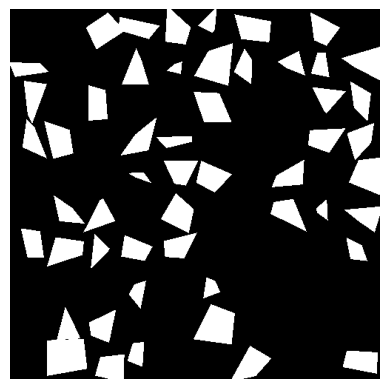

In [3]:
gridData = Create2dGrid(1)
gridData.Create()
gridData.ShowGrid(0)

In [4]:
torch.rand(2) * 100 - 1, torch.rand(2) * 500 - 1

(tensor([17.3160, 64.5134]), tensor([ 81.8989, 396.8006]))

In [ ]:
def GenerateLinearTrajectory(seqLen=252, stateDim=2, start=None, goal=None, dt=0.1):
    if start is None:
        start = torch.rand(stateDim) * 100 
    
    if goal is None:
        goal = torch.rand(stateDim) * 500
        
    total_time = (seqLen - 1) * dt
    vel = (goal - start) / total_time
    
    traj = []
    pos = start.clone()
    for _ in range(seqLen):
        traj.append(pos.clone())
        pos = pos + vel * dt
        
    traj = torch.stack(traj, dim=0)
    noise = torch.randn_like(traj) * 0.01
    traj = traj + noise
    
    return traj

def Show2DTraj(giveTraj, points = []):
    trajToPlot = giveTraj
    x = trajToPlot[:, 0]
    y = trajToPlot[:, 1]
    plt.figure(figsize=(8, 6))
    for pnt in points:
        plt.scatter(np.array(pnt[0]), np.array(pnt[1]), color="purple", s=80, label="Obstacles")
    plt.plot(x.numpy(), y.numpy(), marker="o", markersize=2, color="blue", label="Trajectory")
    plt.scatter(x[0], y[0], color="green", s=80, label="Start")

    plt.scatter(x[-1], y[-1], color="red", s=80, label="Goal")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Drone Trajectory in 2D")
    plt.legend()
    plt.grid(True)
    plt.show()


In [54]:
def ShowTrajInEnv(grid, traj, points=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.cpu().numpy().T, cmap="gray", origin="lower", extent=[0, 500, 0, 500])

    traj_np = traj.detach().cpu().numpy()
    x = traj_np[:, 0]
    y = traj_np[:, 1]

    plt.plot(x, y, color="cyan", linewidth=2, label="Trajectory", alpha=0.8)
    plt.scatter(x[0], y[0], color="green", s=100, label="Start", edgecolors='white', zorder=5)
    plt.scatter(x[-1], y[-1], color="red", s=100, label="Goal", edgecolors='white', zorder=5)
    if points:
        for pnt in points:
            plt.scatter(pnt[0], pnt[1], color="magenta", s=80, label="Point Obstacle")

    plt.title("Trajectory Overlaid on Environment")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [154]:
def CreateDistanceMap(bMask):
    dMap = distance_transform_edt(bMask == 0)
    return torch.from_numpy(dMap).float()

def CreateSignedDistanceMap(bMask):
    dist_outside = distance_transform_edt(bMask == 0)
    dist_inside = distance_transform_edt(bMask == 1)
    sdf = dist_outside - dist_inside
    return torch.from_numpy(sdf).float()

class MapLossFunction(nn.Module):
    def __init__(self, dist_map, w_smooth=5, w_space=1, w_length=9, w_collision=15, safety_radius=15.0):
        super().__init__()
        self.register_buffer('dist_map', dist_map)
        self.w_smooth = w_smooth
        self.w_space = w_space
        self.w_length = w_length
        self.w_collision = w_collision
        self.safety_radius = safety_radius

    def forward(self, traj):
        vel = traj[:, 1:] - traj[:, :-1]
        acc = vel[:, 1:] - vel[:, :-1]
        lossSmooth = (acc ** 2).sum()
        
        segmentLens = torch.norm(vel, dim=-1) + 1e-6
        meanLen = segmentLens.mean(dim=1, keepdim=True)
        lossSpace = ((segmentLens - meanLen) ** 2).sum()
        lossDistance = segmentLens.sum()
        grid_coords = (traj[..., :2] / 249.5) - 1.0
        grid_coords = grid_coords.unsqueeze(1)

        input_map = self.dist_map.unsqueeze(0).unsqueeze(0)
        
        dist_values = F.grid_sample(input_map, grid_coords, mode='bilinear', align_corners=True)

        diff = self.safety_radius - dist_values
        lossCollision = torch.relu(diff).pow(2).sum()

        tLoss = (self.w_smooth * lossSmooth) + \
                (self.w_space * lossSpace) + \
                (self.w_length * lossDistance) + \
                (self.w_collision * lossCollision)
        return tLoss

In [155]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [156]:
# def OptimizeTrajectory(tau, start, end, map, iter = 2500, lr = 0.2):
#     tau = tau.detach().clone().requires_grad_(True).to(device)
#     map = CreateDistanceMap(map)
#     sgdLoss = MapLossFunction(map)
#     optimizer = torch.optim.Adam([tau], lr=lr)
#     for _ in range(iter):
#         optimizer.zero_grad()
#         tauLoss = sgdLoss(tau)
#         tauLoss.backward()
#         optimizer.step()
#         with torch.no_grad():
#             tau[0, 0] = start
#             tau[0, -1] = end
#     return tau

def OptimizeTrajectory(tau, start, end, map_data, iter=10000, lr=0.3):
    tau = tau.detach().clone().to(device).requires_grad_(True)
    map_dist = CreateSignedDistanceMap(map_data).to(device)
    sgdLoss = MapLossFunction(map_dist, safety_radius=30).to(device)
    
    optimizer = torch.optim.Adam([tau], lr=lr)
    
    for _ in range(iter):
        optimizer.zero_grad()
        tau_batched = tau.unsqueeze(0) 
        
        tauLoss = sgdLoss(tau_batched)
        tauLoss.backward()
        optimizer.step()
        with torch.no_grad():
            tau[0] = start.to(device)
            tau[-1] = end.to(device)
            
    return tau.detach().cpu()

In [157]:
# def UpdateMap(map, start, end):
#     def Check(x, y):
#         return x < 500 and x > -1 and y < 500 and y > -1
#     mapCopy = map.clone()
    
#     queue = deque([start, end])
#     while len(queue) != 0:
#         x, y = queue.popleft()
#         print(x, y)
#         if(mapCopy[x][y] != 0):
#             mapCopy[x][y] = 0
#             if(Check(x+1, y)):
#                 queue.append((x+1, y))
#             if(Check(x-1, y)):
#                 queue.append((x-1, y))
#             if(Check(x, y+1)):
#                 queue.append((x, y+1))
#             if(Check(x, y-1)):
#                 queue.append((x, y-1))
#     return mapCopy

def UpdateMap(map_tensor, start, end, radius=20):
    map_copy = map_tensor.clone()
    H, W = map_copy.shape
    
    for pt in [start, end]:
        cx, cy = int(pt[0]), int(pt[1])
        
        x0, x1 = max(0, cx - radius), min(H, cx + radius + 1)
        y0, y1 = max(0, cy - radius), min(W, cy + radius + 1)
        
        map_copy[x0:x1, y0:y1] = 0
        
    return map_copy

In [158]:
def ShowGrid(grid):
    plt.imshow(grid, cmap="gray")
    plt.axis("off")
    plt.show()

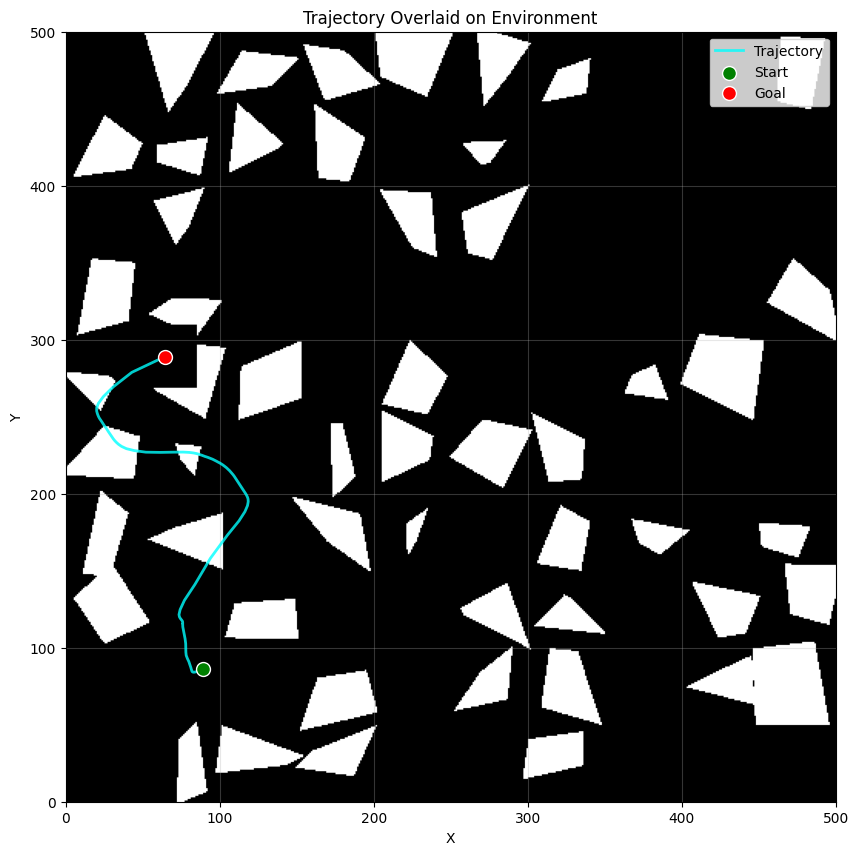

In [159]:
start, goal = torch.rand(2) * 100, torch.rand(2) * 500
gridEnv = UpdateMap(gridData.grid[0], start, goal)

traj = GenerateLinearTrajectory(start = start, goal=goal)


traj = OptimizeTrajectory(traj, start, goal, gridEnv)
ShowTrajInEnv(gridEnv, traj)